# Tutorial to Investigate Chatbot Feedback Types

This notebook demonstrates the full pipeline implemented in the *EduChatEval* package, illustrating a potential use case in the absence of real data.
In this case, it simulates a researcher who is investigating the types and occurences of feedback a given chatbot is providing to 25 students each having on of 5 different tasks. The classification scheme is adapted from the paper by Hansen et al., (2025): http://dx.doi.org/10.7146/lom.v17i31.148831

The steps to do so are as follows:
1. A synthetic framework (i.e., an annotated dataset) is first generated.
2. Next, interactions are simulated between two agents representing a 'student' and a 'tutor'.
3. A BERT classifier is then trained on the synthesized data. 
4. The trained classifier is then applied to the simulated conversation. In this case, only the tutor agent's outputs are analyzed.
5. Finally, the classified data is presented in a descriptive format, showcasing the researchers results. 

In [1]:
# package installation 
!pip install -q --upgrade pip
!pip install -q educhateval
!pip install -q pathlib
!pip install -q pandas

In [9]:
# import libraries
from pathlib import Path
from educhateval import (FrameworkGenerator, 
                        DialogueSimulator,
                        PredictLabels,
                        Visualizer,)

import pandas as pd

In [ ]:
# import generator with the model name and API URL from the local server activated hosted LM studio 
generator = FrameworkGenerator(generator = FrameworkGenerator(
    model_name="llama-3.2-3b-instruct", # the model already downloaded and loaded via LM Studio
    api_url="http://localhost:1234/v1/completions" # the address of locally hosted LM Studio API endpoint that handles generation requests. Consist of server host, port, and path.
    )


# generate the framework for the feedback task given the prompt template
df_feedback = generator.generate_framework(
    prompt_path="../data/templates/prompt_feedback.py", 
    num_samples=300,
    csv_out="../data/generated_tuning_data/synth_feedback_300samples.csv",
)

Generating for category: Advice
Skipping invalid output for category 'Advice': 'choices'
Skipping invalid output for category 'Advice': 'choices'
Skipping invalid output for category 'Advice': 'choices'
Generating for category: Content
Skipping invalid output for category 'Content': 'choices'
Generating for category: Encouragement
Skipping invalid output for category 'Encouragement': 'choices'
Skipping invalid output for category 'Encouragement': 'choices'
Skipping invalid output for category 'Encouragement': 'choices'
Skipping invalid output for category 'Encouragement': 'choices'
Skipping invalid output for category 'Encouragement': 'choices'
Skipping invalid output for category 'Encouragement': 'choices'
Generating for category: Explanation
Skipping invalid output for category 'Explanation': 'choices'
Skipping invalid output for category 'Explanation': 'choices'
Skipping invalid output for category 'Explanation': 'choices'
Skipping invalid output for category 'Explanation': 'choices

#### Quality Filtering
this step is not included in the POC in the paper, but is integrated here for users to run

In [28]:
# loading tiny manually labeled feedback data 
train_data=pd.read_csv("../data/templates/tiny_labeled_feedback.csv")
train_data['category'] = train_data['label'] # renaming to match taxonomy

train_data['category'].unique() 

array(['Advice', 'Content', 'Encouragement', 'Explanation',
       'Posed Question', 'Small Talk', 'Specificity', 'Style'],
      dtype=object)

In [ ]:
# filtering the generated data with a classifier
filtered_df_feedback = generator.filter_with_classifier(
    train_data=train_data,
    synth_data=df_feedback,
    classifier_model_name="google-bert/bert-base-uncased",
    filtered_save_path="../data/generated_tuning_data/final_feedback_300.csv"

)

Max token: 42 Average token: 16.34375


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.189125,0.000000,0.000000,0.000000,0.000000
2,No log,2.037117,0.222222,0.111111,0.222222,0.148148
3,No log,1.971436,0.222222,0.111111,0.222222,0.148148
4,No log,1.978781,0.222222,0.092593,0.222222,0.129630


Map:   0%|          | 0/2322 [00:00<?, ? examples/s]

Filtered data saved to ../data/generated_tuning_data/final_feedback_300.csv


### Dialogue Generation
First the seeds are printed for transparency then looped over

In [44]:
import yaml
# Load YAML file with seed messages
with open("../data/templates/student_seed_overall.yaml", "r") as f:
    seed_messages = yaml.safe_load(f)

# Displaying examples of seed messages for evaluation only
for course_name, course_content in seed_messages.items():
    if course_name != "evaluative_feedback":
        continue  # skip all other courses

    seeds = course_content.get("seeds", [])
    print(f"\nCourse: {course_name}")
    print(f"Number of seeds: {len(seeds)}")
    print("Seed messages:")
    for seed in seeds:
        print(seed)


Course: evaluative_feedback
Number of seeds: 5
Seed messages:
Here’s a paragraph I wrote in English. Could you give me feedback and help me rewrite it together if needed?
I wrote a short essay on the Cold War. I’d love your feedback, and I’ll ask more about anything you point out.
I solved a math problem and explained my reasoning—can you review it? I’d like to revise it if there’s anything unclear.
I created a concept map of the human digestive system. Could you tell me what works well and what could be clearer? I’d like to improve it.
Here’s my summary of a chapter on biodiversity. Please critique it and help me build a stronger version based on your suggestions.


In [10]:
# initiate simulator choosing the backend and model id (either huggingface or local, in this case local)
simulator = DialogueSimulator(backend="mlx", model_id="mlx-community/Qwen2.5-7B-Instruct-1M-4bit")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
%%capture  

# Simulate dialogues for the evaluative feedback task with 5 students per seed and 6 turns per dialogue
all_feedback_dialogues = []

course_name = "evaluative_feedback"
course_content = seed_messages.get(course_name, {})
seeds = course_content.get("seeds", [])

for seed_index, seed_message in enumerate(seeds):
    for student_index in range(5):  # 5 students per seed
        df_single = simulator.simulate_dialogue(
            mode="evaluative_feedback",
            turns=6,
            seed_message_input=seed_message,
            custom_prompt_file="../data/templates/system_prompts.yaml"
        )

        df_single["student_id"] = f"{course_name}_seed{seed_index+1}_student{student_index+1}"
        df_single["course"] = course_name
        all_feedback_dialogues.append(df_single)

# Combine all into a single dataframe
simulated_feedback_df = pd.concat(all_feedback_dialogues, ignore_index=True)


In [58]:
simulated_feedback_df

,turn,student_msg,tutor_msg,student_id,course
0,1,Here’s a paragraph I wrote in English. Could y...,"Sure, please go ahead and share your paragraph...",evaluative_feedback_seed1_student1,evaluative_feedback
1,2,"Here is the paragraph I wrote:\n\n""The city is...",Your paragraph effectively captures the hustle...,evaluative_feedback_seed1_student1,evaluative_feedback
2,3,Thank you for the suggestion! I like the added...,Great job refining your paragraph! Here are so...,evaluative_feedback_seed1_student1,evaluative_feedback
3,4,Thank you for the feedback! I will start the e...,"Great job, you've improved the flow! Here’s a ...",evaluative_feedback_seed1_student1,evaluative_feedback
4,5,Thank you for the additional tweak! I think it...,"Ending with ""vibrant"" reinforces the idea, so ...",evaluative_feedback_seed1_student1,evaluative_feedback
...,...,...,...,...,...
145,2,Got it! Here's my initial summary of the chapt...,Great start! Here are some suggestions to enha...,evaluative_feedback_seed5_student5,evaluative_feedback
146,3,Thank you for the detailed feedback! I appreci...,Absolutely! Here are some examples of specific...,evaluative_feedback_seed5_student5,evaluative_feedback
147,4,Thank you for the additional examples! I think...,Great to hear you found the examples helpful! ...,evaluative_feedback_seed5_student5,evaluative_feedback
148,5,That's a great suggestion! Including a specifi...,Your addition about honeybee populations is ex...,evaluative_feedback_seed5_student5,evaluative_feedback


### Classification and Prediction
Training a classifier on the synthesized framework to predict the categories of the student messages in the dialogue data

In [59]:
predictor = PredictLabels(model_name="distilbert-base-uncased")

In [62]:
predicted_feedback= predictor.run_pipeline(
    train_data=df_feedback, 
    new_data=simulated_feedback_df,
    text_column="text",
    label_column="category", 
    columns_to_classify=["tutor_msg"], 
    split_ratio=0.20,
    prediction_save_path=f"../data/final_outputs/feedback_annotated_final.csv")

Max token: 53 Average token: 32.37210554658051


Map:   0%|          | 0/1857 [00:00<?, ? examples/s]

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.155485,0.952688,0.955318,0.952688,0.952795
2,No log,0.100520,0.976344,0.977100,0.976344,0.976363
3,0.281400,0.081710,0.978495,0.978704,0.978495,0.978457
4,0.281400,0.083868,0.980645,0.981180,0.980645,0.980635


Predicted data saved to ../data/final_outputs/feedback_annotated_final.csv


In [63]:
predicted_feedback

,turn,student_msg,tutor_msg,student_id,course,predicted_labels_tutor_msg,predicted_confidence_tutor_msg
0,1,Here’s a paragraph I wrote in English. Could y...,"Sure, please go ahead and share your paragraph...",evaluative_feedback_seed1_student1,evaluative_feedback,Encouragement,0.966863
1,2,"Here is the paragraph I wrote:\n\n""The city is...",Your paragraph effectively captures the hustle...,evaluative_feedback_seed1_student1,evaluative_feedback,Style,0.998001
2,3,Thank you for the suggestion! I like the added...,Great job refining your paragraph! Here are so...,evaluative_feedback_seed1_student1,evaluative_feedback,Encouragement,0.998581
3,4,Thank you for the feedback! I will start the e...,"Great job, you've improved the flow! Here’s a ...",evaluative_feedback_seed1_student1,evaluative_feedback,Encouragement,0.996998
4,5,Thank you for the additional tweak! I think it...,"Ending with ""vibrant"" reinforces the idea, so ...",evaluative_feedback_seed1_student1,evaluative_feedback,Encouragement,0.968482
...,...,...,...,...,...,...,...
145,2,Got it! Here's my initial summary of the chapt...,Great start! Here are some suggestions to enha...,evaluative_feedback_seed5_student5,evaluative_feedback,Posed Question,0.738326
146,3,Thank you for the detailed feedback! I appreci...,Absolutely! Here are some examples of specific...,evaluative_feedback_seed5_student5,evaluative_feedback,Content,0.815667
147,4,Thank you for the additional examples! I think...,Great to hear you found the examples helpful! ...,evaluative_feedback_seed5_student5,evaluative_feedback,Specificity,0.994304
148,5,That's a great suggestion! Including a specifi...,Your addition about honeybee populations is ex...,evaluative_feedback_seed5_student5,evaluative_feedback,Specificity,0.990093


## Visualizations:
Visualising the descriptive statistics of the classification above

In [76]:
viz = Visualizer()

In [75]:
# Group by predicted label and calculate mean + std of confidence - OBS this is not part of the main pipeline but calculated for reporting purposes
grouped_conf_stats = predicted_feedback.groupby("predicted_labels_tutor_msg")["predicted_confidence_tutor_msg"].agg(
    avg_confidence="mean",
    std_confidence="std"
).reset_index()

grouped_conf_stats


,predicted_labels_tutor_msg,avg_confidence,std_confidence
0,Advice,0.809281,0.196055
1,Content,0.823274,0.148631
2,Encouragement,0.944819,0.105785
3,Posed Question,0.839989,0.151402
4,Small Talk,0.523243,NaN
5,Specificity,0.838946,0.179768
6,Style,0.937165,0.119952


In [79]:
# Summary table
summary = viz.create_summary_table(
    df=predicted_feedback,
    tutor_col="predicted_labels_tutor_msg"
)
summary


,Predicted Category,Tutor (n),Tutor (%)
0,Advice,12,8.0%
1,Content,10,6.7%
2,Encouragement,65,43.3%
3,Posed Question,16,10.7%
4,Small Talk,1,0.7%
5,Specificity,36,24.0%
6,Style,10,6.7%


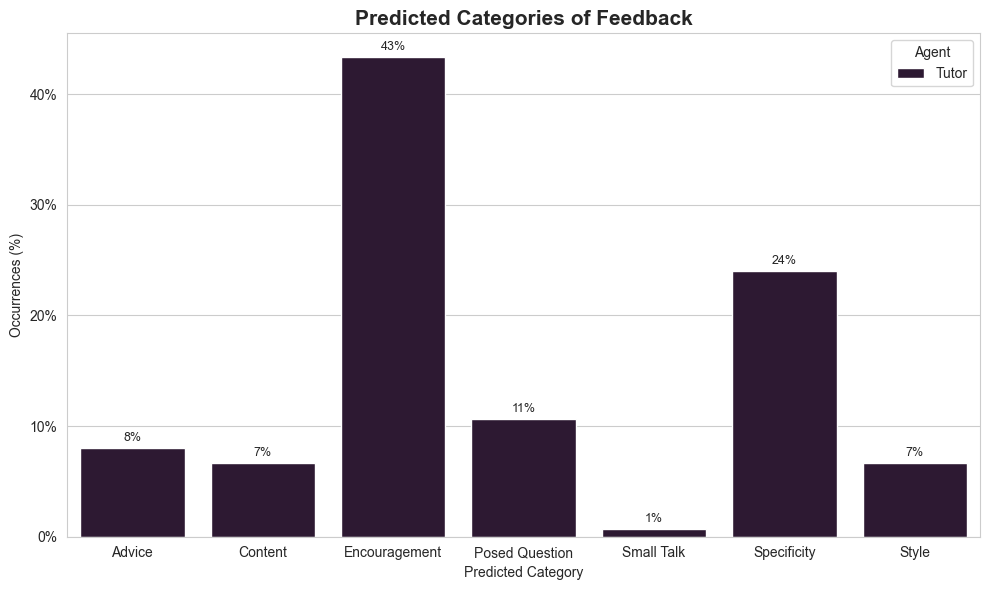

In [104]:
viz.plot_category_bars(
    df=predicted_feedback,
    tutor_col="predicted_labels_tutor_msg",
    use_percent=True,
    title="Predicted Categories of Feedback",
    palette="twilight",
)


når alt andet er done!!!

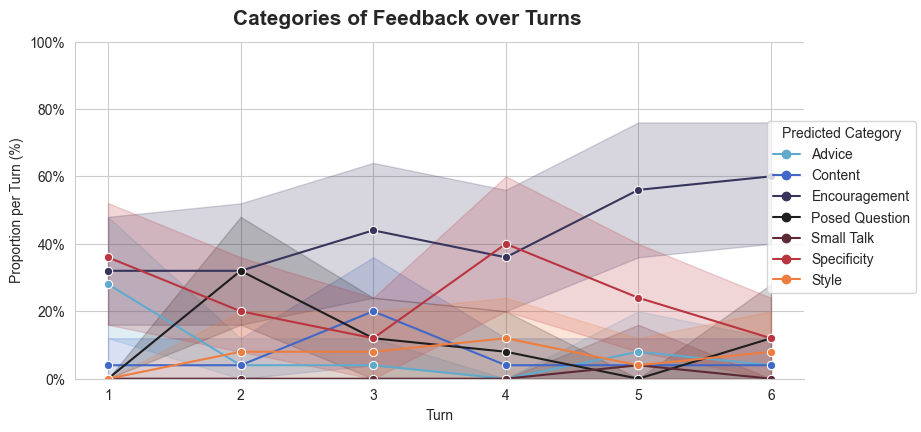

In [7]:
viz.plot_turn_trends(
    df=predicted_feedback,
    tutor_col="predicted_labels_tutor_msg",
    session_col="student_id",  # <- required for CIs
    show_ci=True,
    title="Categories of Feedback over Turns",
)